<a href="https://colab.research.google.com/github/Adam556678/Python-Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Final Projects/Sentiment Analysis/Data/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

(568454, 10)

# Data Preprocessing

In [ ]:
df = df[["Score", "Text"]]

In [ ]:
def map_sentiment(score):
    if score <= 2:
        return 0
    else:
        return 1

df['label'] = df['Score'].apply(map_sentiment)
df.drop('Score', inplace=True, axis=1)

In [ ]:
df.head()

,Text,label
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


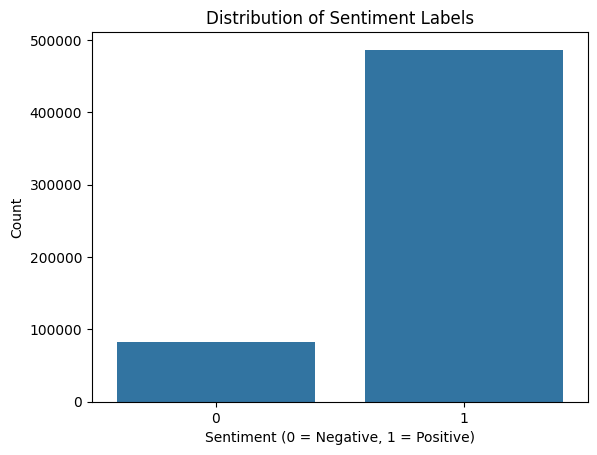

In [ ]:
def plot_sent_labels_count(data, title=None):
    sns.countplot(data=data, x='label')
    plt.title(title)
    plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
    plt.ylabel('Count')
    plt.show()

plot_sent_labels_count(data=df, title='Distribution of Sentiment Labels')

Undersampling Positive Sentiments

In [ ]:
!pip install imbalanced-learn

In [ ]:
X, y = df[['Text']].to_numpy(), df[['label']].to_numpy()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')

X_resampled, y_resampled = undersample.fit_resample(X, y)

In [ ]:
X_df_resampled = pd.Series(X_resampled.flatten(), name='Text')
y_df_resampled = pd.Series(y_resampled.flatten(), name='label')

resampled_df = pd.concat([X_df_resampled, y_df_resampled], axis=1)

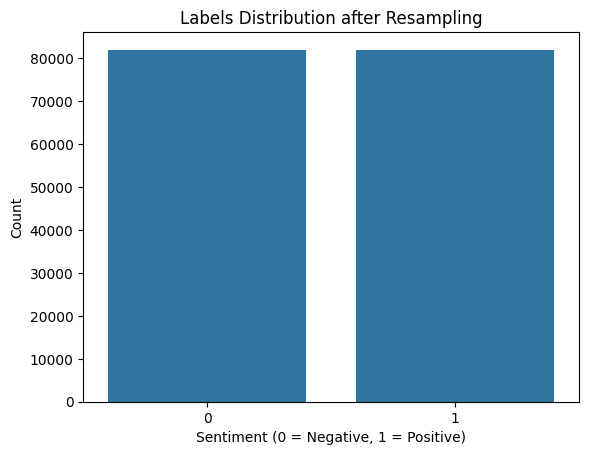

In [ ]:
plot_sent_labels_count(data=resampled_df, title='Labels Distribution after Resampling')

#Model Training

##BERT Model

In [ ]:
from transformers import BertTokenizerFast
from transformers import BertModel

model_id="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

###Preparing Data for BERT Model

tokenize data

In [ ]:
def preprocess_tokenizer(examples):
    return tokenizer(examples["Text"], padding=True, truncation=True)

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
from datasets import Dataset

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(resampled_df)

# Tokenize with batching
tokenized_dataset = hf_dataset.map(preprocess_tokenizer, batched=True)

Map:   0%|          | 0/164074 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['Text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 164074
})

Split Data

In [ ]:
BATCH_SIZE = 8

In [ ]:
# train-test split the dataset
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

# create Tensorflow dataset for train data
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size = BATCH_SIZE
)

# create Tensorflow dataset for test data
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size = BATCH_SIZE
)

Restructure Data Format for BERT Model

In [ ]:
def restructure_data_format(data):
    return {
        'input_ids' : data['input_ids'],
        'token_type_ids' : data['token_type_ids'],
        'attention_mask' : data['attention_mask']
    }, data['label']

In [ ]:
tf_train_dataset = tf_train_dataset.map(restructure_data_format).prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.map(restructure_data_format).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in tf_train_dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[  101,  2009,  1005, ...,     0,     0,     0],
       [  101,  2023, 12901, ...,     0,     0,     0],
       [  101,  1045,  2293, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2941, ...,  1012,  1012,   102],
       [  101,  2054,  2064, ...,     0,     0,     0],
       [  101,  2026,  3899, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, nu

###Modeling

In [ ]:
from transformers import TFBertForSequenceClassification

model=TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)
model.summary()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training

In [ ]:
from transformers import create_optimizer

EPOCHS = 3
num_train_steps = (len(tokenized_dataset["train"]) // BATCH_SIZE) * EPOCHS
opt, _ = create_optimizer(init_lr=2e-5, num_train_steps=num_train_steps, num_warmup_steps=0)

Compiling

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=opt,
              metrics=["accuracy"])

Fitting

In [ ]:
history = model.fit(tf_train_dataset.take(1000),
                    validation_data=tf_val_dataset,
                    epochs=EPOCHS)

Epoch 1/3
1000/1000 [==============================] - 2326s 2s/step - loss: 0.5515 - accuracy: 0.8310 - val_loss: 0.3597 - val_accuracy: 0.8849
Epoch 2/3
1000/1000 [==============================] - 2272s 2s/step - loss: 0.4628 - accuracy: 0.8622 - val_loss: 0.4996 - val_accuracy: 0.8409
Epoch 3/3
1000/1000 [==============================] - 2273s 2s/step - loss: 0.4730 - accuracy: 0.8395 - val_loss: 0.4197 - val_accuracy: 0.9029


Save BERT Model

In [ ]:
import json

def save_history(model_history ,model_name):
    with open(f"{model_name}_history.json", 'w') as f:
        json.dump(model_history.history, f)

def load_history(file):
    with open(file, 'r') as f:
        return json.load(f)

In [ ]:
# save BERT model
model.save("my_bert_model")

# save model's history for comparison (later)
save_history(history, 'bert')

Plot Model's Loss & Accuracy

In [ ]:
def plot_val_train_loss(model_history, model_name=None):
    plt.plot(model_history["loss"])
    plt.plot(model_history["val_loss"])

    plt.title(f"{model_name} Model Loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.legend(["train loss", "val loss"], loc="bottom left")
    plt.show()

In [ ]:
def plot_val_train_acc(model_history, model_name=None):
    plt.plot(model_history["accuracy"])
    plt.plot(model_history["val_accuracy"])

    plt.title(f"{model_name} Model Accuracy")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.legend(["train accuracy", "val accuracy"], loc="bottom left")
    plt.show()

In [ ]:
bert = TFBertForSequenceClassification.from_pretrained("my_bert_model")

OSError: Error no file named tf_model.h5, model.safetensors or pytorch_model.bin found in directory my_bert_model.

In [ ]:
# loading BERT history
bert_history = load_history('bert_history.json')

# plotting BERT loss
plot_val_train_loss(bert_history, 'BERT')

In [ ]:
# plotting BERT Accuracy
plot_val_train_acc(bert_history, 'BERT')

##Naive Bayes